## A Very Simple ``Dash`` App

In [1]:
from dash import Dash, html, Output, Input

app = Dash()

app.layout = html.Div([
    html.H1("A Simple App", id="title"),
    html.P("Structure things like you would in HTML"),
    html.Button("Click me to do something", id="button"),
])

@app.callback(
    Output("title", "children"), # change this value
    Input("button", "n_clicks"), # when this changes
    prevent_initial_call = True
)
def update_title_on_buttonclick(n_clicks):
    print(n_clicks) # sure why not
    return "A Simple App **That Does Things!**"

#app.run()

## A Bit More Complicated App

Let's use bootstrap to spruce this up a bit

In [2]:
import dash_bootstrap_components as dbc
from dash import dcc

app = Dash(external_stylesheets=[dbc.themes.DARKLY])

app.layout = html.Div(
    [
        dbc.NavbarSimple(brand="Communities in Network Graphs"),
        dbc.Container(
            [
                dbc.Row(
                    [
                        dbc.Col(
                            [
                                html.H3("Customize Lorems"),
                                dbc.InputGroup(
                                    [
                                        dbc.InputGroupText("N Paras: "),
                                        dbc.Input(
                                            value=2, type="number", id="n_paragraphs"
                                        ),
                                    ]
                                ),
                                dbc.InputGroup(
                                    [
                                        dbc.InputGroupText("Color: "),
                                        dcc.Dropdown(
                                            value=None,
                                            options=[
                                                {"label": o, "value": f"var(--bs-{o})"}
                                                for o in [
                                                    "red",
                                                    "green",
                                                    "blue",
                                                    "black",
                                                    "purple"
                                                ]
                                            ],
                                            id="color",
                                            style={"color":"black"} # play nice (ish) with dark themes
                                        ),
                                    ]
                                ),
                            ],
                            width=4,
                        ),
                        dbc.Col([html.H2("Lorems Ipsum"), html.P(id="paragraph")], width=8),
                    ]
                )
            ]
        ),
    ]
)


@app.callback(
    {"text": Output("paragraph", "children"), "style": Output("paragraph", "style")},
    Input("n_paragraphs", "value"),
    Input("color", "value"),
)
def generate_paragraphs(n, color):
    print(n, color)
    return dict(text=[html.P(p) for p in fake.paragraphs(nb=n)], style={"color": color})


#app.run(debug=False)


## Cytoscape

Now we can use the `dash-cytoscape` package to display our graph. Let's start with wireframe layout and then add in the functionality we need:

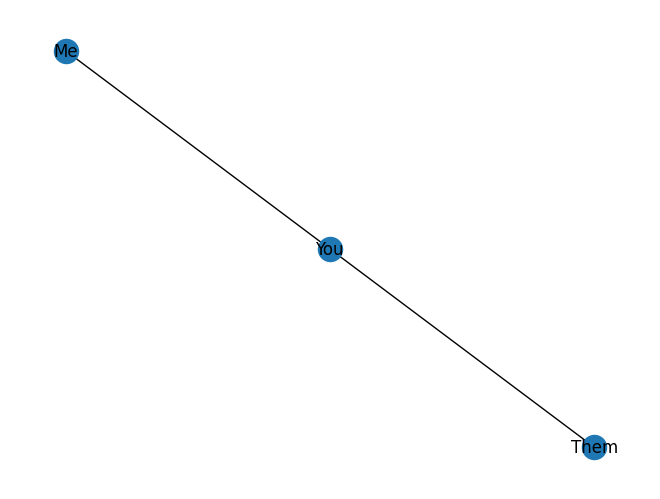

Mrs.
Ms.
Mx.
Misc.
Dr.
Mr.
Miss
Ind.
😟


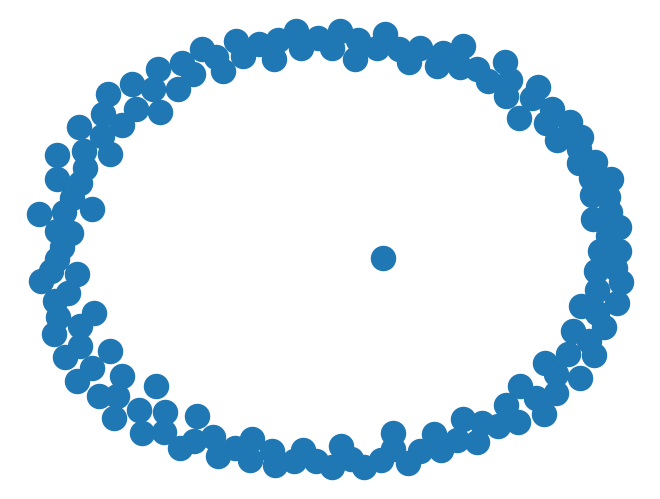

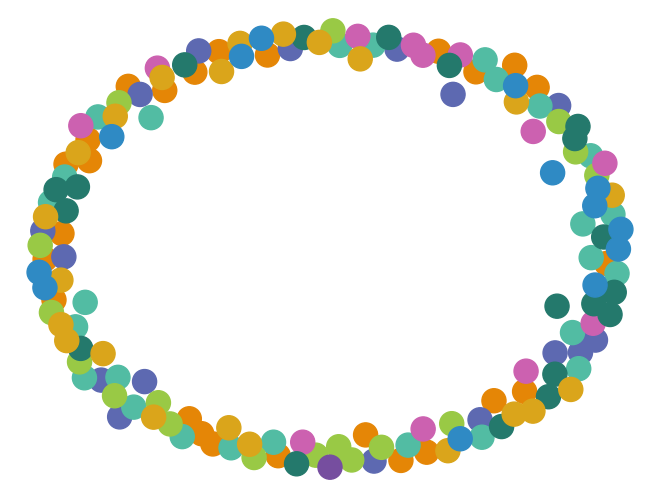

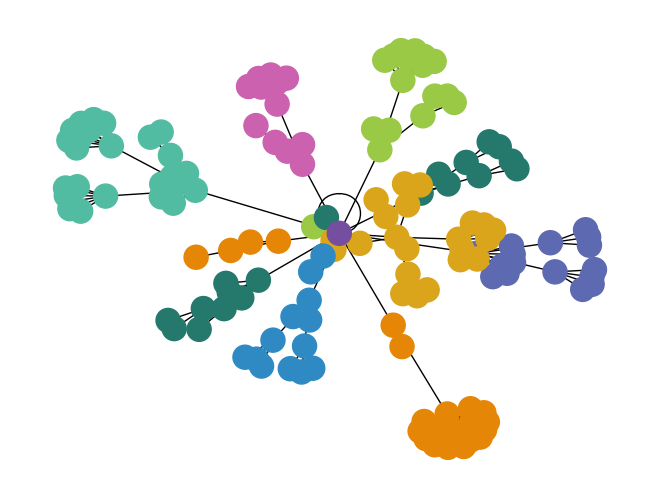

In [3]:
%run "../Part 2 - Clustered Graph Attributes/Solution.ipynb"


Here we need to collect our functions from the past notebooks into something that's easy to call all at once:

In [4]:
import pandas as pd
import networkx as nx

def create_graph(people_df: pd.DataFrame, attributes:list[str]) -> nx.DiGraph:
    G = nx.DiGraph()
    
    # add nodes

    # add attributes

    return G

And, let's take our graph and make it something cytoscape can understand with `nx.cytoscape_data`

In [ ]:

def create_elements(attributes: list[str]=[]) -> list[dict]:
    """Generate a graph with connecting attributes and serialize it as cytoscape elements"""

    G = create_graph(people_df=people_df, attributes=attributes)
    elements = [{}]
    return elements

Let's just drop in this monster and tweak it later ... there's lots to explore in [cytoscape land](https://js.cytoscape.org/#style/mappers) but we don't need to do it all at once

In [5]:

def stylesheet_(focus:str=CEO["name"], theme:str="light", color:str=None, show_names:bool=False):
    dark = theme == "dark"
    return [
    {
        "selector": "node",
        "style": {
            "font-size": 50,
            "color": "lightgrey" if dark else "darkgrey"
        }
    },
    {
        "selector": "edge",
        "style": {
            "line-color": "lightgrey" if dark else "darkgrey",
            "color": "lightgrey" if dark else "darkgrey",
            "curve-style": "bezier",
            "label": "data(label)",
            "width": 1,
            "opacity": 0.25,
            "font-size": 10,
            "text-rotation": "autorotate",
        },
    },    
    {"selector": "edge[?languages]", "style": {"label": "codes"}},
    {"selector": "edge[?tz]", "style": {"label": "lives in"}},
    {"selector": "edge[?team]", "style": {"label": "belongs to"}},
    {"selector": "edge[?apps]", "style": {"label": "uses"}},
    {"selector": "edge[?manager]", "style": {"label": "manages", "source-arrow-shape":"triangle"}},     
    {
        "selector": "node[?person]",
        "style": {
            "label": "data(name)" if show_names else "",
            "background-color": "lightgreen" if dark else "green",
            "width": 25,
            "height": 25,            
            "font-size": 16
        },
    },
    {
        "selector": "node[!person]",
        "style": {
            "label": "data(name)",
            "background-color": "white" if dark else "black",
            "width": 5,
            "height": 5,
        },
    },
    {
        "selector": f"node[id='{focus}']",
        "style":{
            "width": 25,
            "height": 25,
            "font-size": 20,
            "color":"skyblue",
            "background-color":"skyblue",
            "z-index":10            
        }
    },
    *node_color_stylesheet(attribute=color)
]

def node_color_stylesheet(attribute:str) -> dict:
    if not attribute:
        return []
    #colorscale = [f"var(--bs-{color})" for color in ["red","green","blue","pink","purple","yellow","indigo","cyan","orange","teal"]]
    colorscale = [color for color in ["red","green","blue","pink","purple","yellow","indigo","cyan","orange","teal"]]
    colors = dict(zip(expanded_df[attribute].unique(),colorscale))
    return [
        {"selector": f"node[{attribute}='{value}']", "style":{"background-color":color}}
        for value,color in colors.items()
    ]

We need to define a layout for our graph, just like with networkx. Here we use [cose](https://js.cytoscape.org/#layouts/cose), which is a nice force-directed layout with *lots* of tuning parameters. Here's a starting point that seemed to work well in tests:

In [ ]:
cyto_layout = {
    "name": "cose",
    "idealEdgeLength": 100,
    "nodeOverlap": 20,
    "refresh": 20,
    "fit": True,
    "padding": 30,
    "randomize": False,
    "componentSpacing": 100,
    "nodeRepulsion": 400000,
    "edgeElasticity": 100,
    "nestingFactor": 5,
    "gravity": 80,
    "numIter": 1000,
    "initialTemp": 200,
    "coolingFactor": 0.95,
    "minTemp": 1.0,
    "nodeDimensionsIncludeLabels": True,
}


Now the app:

In [6]:
from dash import dash, html, dcc, Input, Output
import dash_cytoscape as cyto

cyto.load_extra_layouts()
dashboard = dash.Dash(__name__, external_stylesheets=[dbc.themes.DARKLY])


dropdowns = [
    dbc.InputGroup(
        [
            dbc.InputGroupText("Attributes: "),
            dcc.Dropdown(
                value=None,
                options=[{"label": o, "value": o} for o in expanded_df.columns],
                id="attributes",
                placeholder="attrs as nodes",
                style={
                    "color": "black",
                    "min-width": "75px",
                },  # play nice (ish) with dark themes
                multi=True,
            ),
        ]
    ),
    dbc.InputGroup(
        [
            dbc.InputGroupText("Color: "),
            dcc.Dropdown(
                value=None,
                options=[{"label": o, "value": o} for o in expanded_df.columns],
                id="color",
                placeholder="attr as colors",
                style={
                    "color": "black",
                    "min-width": "75px",
                },  # play nice (ish) with dark themes
            ),
        ]
    ),
]


def layout():
    network = cyto.Cytoscape(
        id="network",
        layout=cyto_layout,
        responsive=True,
        style={"width": "100%", "height": "800px"},
        elements=create_elements(attributes=["team", "city"]),
        stylesheet=stylesheet_(theme="dark", color="country"),
    )
    return html.Div(
        [
            dbc.NavbarSimple(
                [
                    dbc.NavItem(
                        dbc.NavLink(
                            "PyData Seattle 2023",
                            href="https://pydata.org/seattle2023/schedule/",
                        )
                    ),
                    dbc.NavItem(
                        dbc.NavLink(
                            "Network Graph Tutorial",
                            href="https://lucasdurand.xyz/network-graph-tutorial",
                        )
                    ),
                    dbc.NavItem(
                        dbc.NavLink(
                            "Talk",
                            href="https://seattle2023.pydata.org/cfp/talk/83P9D7/",
                        )
                    ),
                ],
                brand="Peer Finder",
            ),
            dbc.Container(
                [
                    dbc.Row(
                        [
                            dbc.Col([html.H3("[TODO] Draw Graph by Attributes"),
                                *dropdowns],
                                width=4,
                                style={"background-color": "var(--bs-dark)"},
                            ),
                            dbc.Col(network, width=8),
                        ]
                    )
                ]
            ),
        ]
    )


dashboard.layout = layout

if __name__ == "__main__":
    dashboard.run(port=16900, debug=True, use_reloader=False)


Dash is running on http://127.0.0.1:16900/

 * Serving Flask app '__main__'
 * Debug mode: on


In [ ]:
app = dashboard.server
print("app loaded")

## Extras

The rest is really ... easy? Now you have a foundation for working with graphs in Python, and rendering them in Dash :)

* Change node size based on `rank` using a calculation
* Customize the layout
* Add a callback that uses a dropdown to choose how to colour nodes
    * Pick an attribute to color on people nodes like plotly
    * Color attribute nodes more statically
* Add a callback that uses a dropdown to pick which attributes are nodified
* Set the layout settings from user input
* Add callbacks to render a tooltip with node information when clicked: check out [cytoscape events](https://dash.plotly.com/cytoscape/events) for the recipe